In [1]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import itertools as it
from statsmodels.sandbox.stats.multicomp import multipletests
import statsmodels.api as sm
#import nltk
import scipy.stats as st
import statsmodels.formula.api as smf
import seaborn as sns
import Helper as hp

#Load Data
data = pd.read_csv("CHI_2019_FULL.csv")

#Set Labels 
emotion_label = ['Anger', 'Boredom', 'Disgust', 'Fear', 'Happiness', 'Emo_Neutral', 'Sadness']
affect_label = ['Aggressiv', 'Cheerful', 'Intoxicated', 'Nervous', 'Aff_Neutral', 'Tired']
loi_label = ['Disinterest', 'Normal', 'High Interest']

#Get specific data and save it into new data frames
# We use the pandas .copy(deep=True) function to prevent the SettingWithCopyWarning we would otherwise get. Since we do
# not write, but only read from the data, the warning does not affect the data frames
df_emotion = data[['Anger', 'Boredom', 'Disgust', 'Fear', 'Happiness', 'Emo_Neutral', 'Sadness', 'Filename']].copy(deep=True)
df_affect = data[['Aggressiv', 'Cheerful', 'Intoxicated', 'Nervous', 'Aff_Neutral', 'Tired', 'Filename']].copy(deep=True)
df_loi = data[['Disinterest', 'Normal', 'High Interest', 'Filename']].copy(deep=True)
df_ar_val = data[['Arousal', 'Valence', 'Filename']].copy(deep=True)
#For further usage, we want to append the CharacterID as a column, which is saved with other information in the filename
#Since we only want the digits, we can remove all non-digit characters of the filename column and append the column to the df

df_emotion['Char_ID'] = df_emotion['Filename'].replace('\D+','', regex = True).copy(deep=True)
df_affect['Char_ID'] = df_affect['Filename'].replace('\D+','', regex = True).copy(deep=True)
df_loi['Char_ID'] = df_loi['Filename'].replace('\D+','', regex = True).copy(deep=True)
df_ar_val['Char_ID'] = df_ar_val['Filename'].replace('\D+','', regex = True).copy(deep=True)

#Load data about speakers
char_data = pd.read_csv("CHI_2019_CharacterData.csv")  

#Join above tables and Character Tables

#To Join DataFrames we have to cast the column on which we want to join to int, so that both columns have the same data type
char_data['ID'] = char_data['ID'].astype(int)
df_ar_val['Char_ID'] = df_ar_val['Char_ID'].astype(int)
df_emotion['Char_ID'] = df_emotion['Char_ID'].astype(int)
df_affect['Char_ID'] = df_affect['Char_ID'].astype(int)
df_loi['Char_ID'] = df_loi['Char_ID'].astype(int)

#Safe new data frames
df_ar_val_char = df_ar_val.merge(char_data, how = 'left', left_on='Char_ID', right_on='ID')
df_emotion_char = df_emotion.merge(char_data, how = 'left', left_on='Char_ID', right_on= 'ID')
df_affect_char = df_affect.merge(char_data, how = 'left', left_on='Char_ID', right_on= 'ID')
df_loi_char = df_loi.merge(char_data, how = 'left', left_on='Char_ID', right_on= 'ID')

In [2]:
#Because we need information about the Sentence type, i.e. if the wav file is a question/ answers or a snippet from the talk
#This is why we use the merged table containing the Filename which contains information about Sentence Type

#Get Information of Sentence Type: It's coded in the last character, e.g. 9_a_q.wav is the first (a) sample of person with ID = 9, and it's 
#a question (q). If it would be an answer, instead of the q, and a would be inplace. If the sample is taken from the presentation it is indicated with a p
sentence_type = df_ar_val_char.Filename.str.replace('\d+','').str[3:-4]
df_ar_val_char['SentenceType'] = sentence_type

df_questions = df_ar_val_char.loc[df_ar_val_char['SentenceType'] == 'q']
df_questions = df_questions.drop_duplicates(subset = ['Char_ID'], keep = 'first')
df_answers = df_ar_val_char.loc[df_ar_val_char['SentenceType'] == 'a']
df_answers = df_answers.drop_duplicates(subset = ['Char_ID'], keep = 'first')
df_presentation = df_ar_val_char.loc[df_ar_val_char['SentenceType'] == 'p']
df_presentation = df_presentation.drop_duplicates(subset = ['Char_ID'], keep = 'first')

df_ar_val_char = df_ar_val_char.drop_duplicates(subset = ['Char_ID'], keep = 'first')

print('Male/Female overall (in questions and answers):')
print(df_ar_val_char['Sex'].value_counts())
print('Male/Female in Questions:')
print(df_questions['Sex'].value_counts())
print('Male/Female in Answers:')
print(df_answers['Sex'].value_counts())
print('Male/Female in Presentations:')
print(df_presentation['Sex'].value_counts())

print('\nGrad Student/PhD overall (in questions and answers):')
print(char_data['Academic Status'].value_counts())
print('Grad Student/PhD in Questions:')
print(df_questions['Academic Status'].value_counts())
print('Grad Student/PhD in Answers:')
print(df_answers['Academic Status'].value_counts())
print('Grad Student/PhD in Presentations:')
print(df_presentation['Academic Status'].value_counts())

print('\nNative Speaker overall (in questions and answers):')
print(char_data['IsNativeSpeaker'].value_counts())
print('Native Speaker in Questions:')
print(df_questions['IsNativeSpeaker'].value_counts())
print('Native Speaker in Answers:')
print(df_answers['IsNativeSpeaker'].value_counts())
print('Native Speaker in Presentations:')
print(df_presentation['IsNativeSpeaker'].value_counts())

Male/Female overall (in questions and answers):
Male      163
Female    109
Name: Sex, dtype: int64
Male/Female in Questions:
Male      123
Female     70
Name: Sex, dtype: int64
Male/Female in Answers:
Male      40
Female    40
Name: Sex, dtype: int64
Male/Female in Presentations:
Female    41
Male      40
Name: Sex, dtype: int64

Grad Student/PhD overall (in questions and answers):
Grad Student    41
PhD             39
Name: Academic Status, dtype: int64
Grad Student/PhD in Questions:
Grad Student    2
Name: Academic Status, dtype: int64
Grad Student/PhD in Answers:
Grad Student    40
PhD             39
Name: Academic Status, dtype: int64
Grad Student/PhD in Presentations:
Grad Student    41
PhD             39
Name: Academic Status, dtype: int64

Native Speaker overall (in questions and answers):
Native Speaker       162
Europ. Non-Native     58
Asian Non-Native      53
Latin America          1
Name: IsNativeSpeaker, dtype: int64
Native Speaker in Questions:
Native Speaker       126
E

# Let's have a look at some basic statistics

### Emotion

In [3]:
df_emotion[emotion_label].describe()

,Anger,Boredom,Disgust,Fear,Happiness,Emo_Neutral,Sadness
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,0.015760,0.059745,0.220173,0.007894,0.008740,0.010922,0.676767
std,0.045212,0.106697,0.251497,0.018218,0.015133,0.025054,0.301704
min,0.000005,0.000001,0.000440,0.000000,0.000005,0.000000,0.004776
25%,0.000929,0.001613,0.027749,0.000195,0.000594,0.000118,0.428427
50%,0.003426,0.010098,0.121976,0.001038,0.001856,0.000879,0.791905
75%,0.015300,0.062913,0.324496,0.007856,0.009771,0.009174,0.954756
max,0.868391,0.522867,0.981149,0.257043,0.120002,0.252899,0.999262


### Affect

In [4]:
df_affect[affect_label].describe()

,Aggressiv,Cheerful,Intoxicated,Nervous,Aff_Neutral,Tired
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,0.183831,0.412228,0.127050,0.033077,0.060317,0.183497
std,0.101924,0.118707,0.046384,0.013475,0.026155,0.177851
min,0.000228,0.000019,0.001914,0.000015,0.000003,0.004185
25%,0.117660,0.355368,0.099934,0.026487,0.044150,0.073607
50%,0.172849,0.433153,0.122847,0.030633,0.056839,0.113717
75%,0.228845,0.494440,0.146628,0.036762,0.073191,0.222184
max,0.898450,0.643551,0.482587,0.170738,0.178175,0.997821


### Level of Interest

In [5]:
df_loi[loi_label].describe()

,Disinterest,Normal,High Interest
count,635.000000,635.000000,635.000000
mean,0.011502,0.494105,0.494392
std,0.013826,0.305831,0.310571
min,0.000001,0.000002,0.006140
25%,0.003500,0.213612,0.197744
50%,0.007715,0.504883,0.487307
75%,0.014033,0.779956,0.777558
max,0.147931,0.986748,0.999997


### Arousal-Valence

In [6]:
df_ar_val[['Arousal','Valence']].describe()

,Arousal,Valence
count,635.000000,635.000000
mean,0.129567,0.047348
std,0.109614,0.080280
min,-0.246181,-0.264416
25%,0.053401,-0.005805
50%,0.126646,0.043928
75%,0.204519,0.100907
max,0.827725,0.296576


# Let's have a look at our individuals..

... We select the min and maximum value of each feature and then locate the id of the person to which the min/ max value corresponds. With the usage of the ID, we then take a look at all values of this person (concerning the attribute where she/ he had their min/max value), so that we can evaluate, if one recording of a person is similar to an other one.

First we start with all emotions, so anger, boredom, disgust, fear, happy, neutral and sad. Note, that we take all values into account, so there also may be only one value, as we look for the max value of all answers, presentations and questions.

In [7]:
# Let's start with emotions, let's start with anger
anger = df_emotion_char['Anger'].idxmax()
anger_c_ID = df_emotion_char['ID'][anger]
anger_c_df = df_emotion_char.loc[df_emotion_char['ID'] == anger_c_ID]
anger_c_df = anger_c_df['Anger']

#Now do Boredom
boredom = df_emotion_char['Boredom'].idxmax()
bore_c_ID = df_emotion_char['ID'][boredom]
bore_c_df = df_emotion_char.loc[df_emotion_char['ID'] == bore_c_ID]
bore_c_df = bore_c_df['Boredom']

#Now do Disgust
disgust = df_emotion_char['Disgust'].idxmax()
disg_c_ID = df_emotion_char['ID'][disgust]
disg_c_df = df_emotion_char.loc[df_emotion_char['ID'] == disg_c_ID]
disg_c_df = disg_c_df['Disgust']

#Now to Fear
fear = df_emotion_char['Fear'].idxmax()
fear_c_ID = df_emotion_char['ID'][fear]
fear_c_df = df_emotion_char.loc[df_emotion_char['ID'] == fear_c_ID]
fear_c_df = fear_c_df['Fear']

#Now to Happiness
happy = df_emotion_char['Happiness'].idxmax()
happy_c_ID = df_emotion_char['ID'][happy]
happy_c_df = df_emotion_char.loc[df_emotion_char['ID'] == happy_c_ID]
happy_c_df = happy_c_df['Happiness']

#Now to Emo_Neutral
emo_n = df_emotion_char['Emo_Neutral'].idxmax()
emo_n_c_ID = df_emotion_char['ID'][emo_n]
emo_n_c_df = df_emotion_char.loc[df_emotion_char['ID'] == emo_n_c_ID]
emo_n_c_df = emo_n_c_df['Emo_Neutral']

#Now to Sadness
sad = df_emotion_char['Sadness'].idxmax()
sad_c_ID = df_emotion_char['ID'][sad]
sad_c_df = df_emotion_char.loc[df_emotion_char['ID'] == sad_c_ID]
sad_c_df = sad_c_df['Sadness']

max anger person: 237


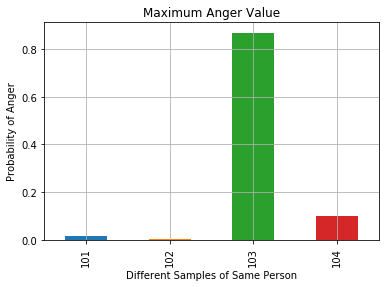

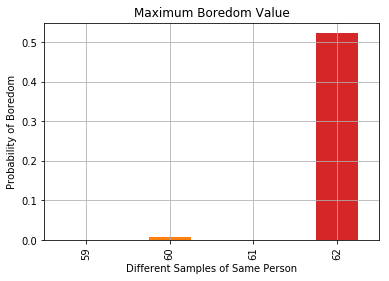

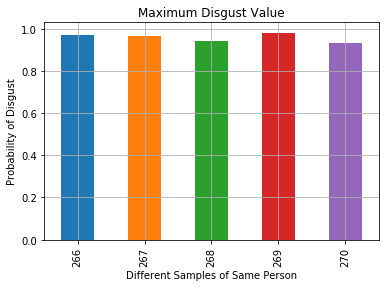

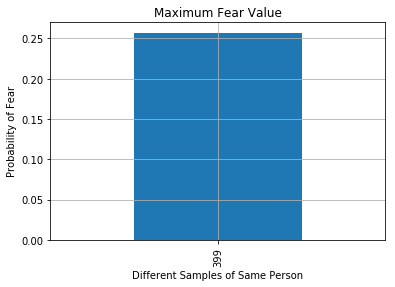

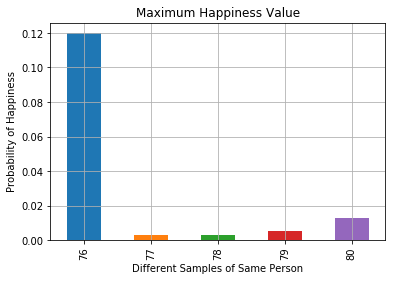

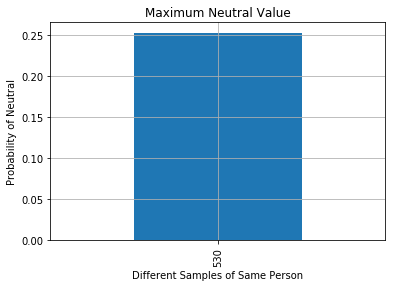

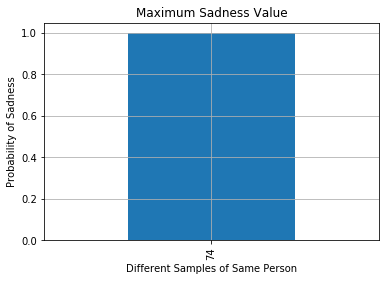

In [8]:
ax_anger = anger_c_df.plot.bar(title = 'Maximum Anger Value')
ax_anger.set_ylabel('Probability of Anger')
ax_anger.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_bore = bore_c_df.plot.bar(title = 'Maximum Boredom Value')
ax_bore.set_ylabel('Probability of Boredom')
ax_bore.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_disg = disg_c_df.plot.bar(title = 'Maximum Disgust Value')
ax_disg.set_ylabel('Probability of Disgust')
ax_disg.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_fear = fear_c_df.plot.bar(title = 'Maximum Fear Value')
ax_fear.set_ylabel('Probability of Fear')
ax_fear.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_happy = happy_c_df.plot.bar(title = 'Maximum Happiness Value')
ax_happy.set_ylabel('Probability of Happiness')
ax_happy.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_emo_neu = emo_n_c_df.plot.bar(title = 'Maximum Neutral Value')
ax_emo_neu.set_ylabel('Probability of Neutral')
ax_emo_neu.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()


ax_sad = sad_c_df.plot.bar(title = 'Maximum Sadness Value')
ax_sad.set_ylabel('Probability of Sadness')
ax_sad.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

In the above plots we can see, that although persons having a max emotion value it does not mean that all other samples also have similar high values. This can be seen in the anger, boredom and happiness plot.

Furthermore, we can see that the maximum values of disgust and sadness are very high (near 1) in contrast to e.g. happiness, where the max value is only around 0.12.

All in all this means that the values vary between emotion samples. 

Now let's take a look at attributes of affect.

In [9]:
# Let's start with Aggressiv
agg = df_affect_char['Aggressiv'].idxmax()
agg_c_ID = df_affect_char['ID'][agg]
agg_c_df = df_affect_char.loc[df_affect_char['ID'] == agg_c_ID]
agg_c_df = agg_c_df['Aggressiv']

#Now do Cheerful
cheer = df_affect_char['Cheerful'].idxmax()
cheer_c_ID = df_affect_char['ID'][cheer]
cheer_c_df = df_affect_char.loc[df_affect_char['ID'] == cheer_c_ID]
cheer_c_df = cheer_c_df['Cheerful']

#Now do Intoxicated
intoxi = df_affect_char['Intoxicated'].idxmax()
intoxi_c_ID = df_affect_char['ID'][intoxi]
intoxi_c_df = df_affect_char.loc[df_affect_char['ID'] == intoxi_c_ID]
intoxi_c_df = intoxi_c_df['Intoxicated']

#Now to Nervous
nerv = df_affect_char['Nervous'].idxmax()
nerv_c_ID = df_affect_char['ID'][nerv]
nerv_c_df = df_affect_char.loc[df_affect_char['ID'] == nerv_c_ID]
nerv_c_df = nerv_c_df['Nervous']

#Now to Aff_Neutral
aff_n = df_affect_char['Aff_Neutral'].idxmax()
aff_n_c_ID = df_affect_char['ID'][aff_n]
aff_n_c_df = df_affect_char.loc[df_affect_char['ID'] == aff_n_c_ID]
aff_n_c_df = aff_n_c_df['Aff_Neutral']

#Now to Tired
tired = df_affect_char['Tired'].idxmax()
tired_c_ID = df_affect_char['ID'][tired]
tired_c_df = df_affect_char.loc[df_affect_char['ID'] == tired_c_ID]
tired_c_df = tired_c_df['Tired']

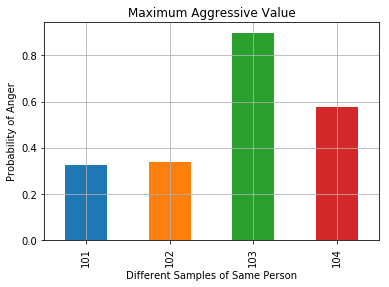

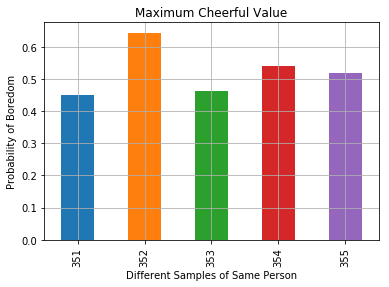

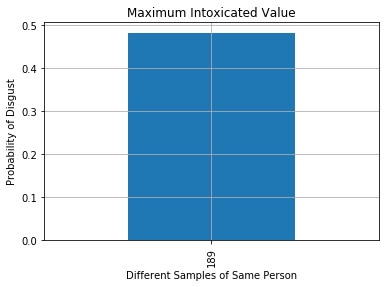

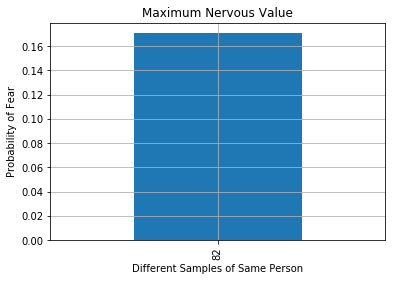

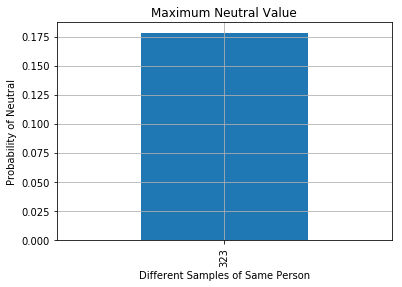

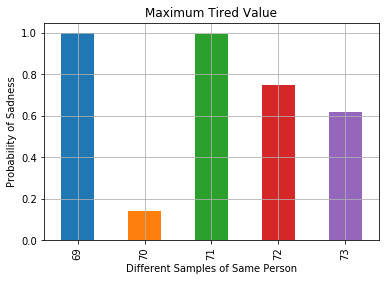

In [10]:
ax_agg = agg_c_df.plot.bar(title = 'Maximum Aggressive Value')
ax_agg.set_ylabel('Probability of Anger')
ax_agg.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_cheer = cheer_c_df.plot.bar(title = 'Maximum Cheerful Value')
ax_cheer.set_ylabel('Probability of Boredom')
ax_cheer.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_intoxi = intoxi_c_df.plot.bar(title = 'Maximum Intoxicated Value')
ax_intoxi.set_ylabel('Probability of Disgust')
ax_intoxi.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_nerv = nerv_c_df.plot.bar(title = 'Maximum Nervous Value')
ax_nerv.set_ylabel('Probability of Fear')
ax_nerv.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_aff_neu = aff_n_c_df.plot.bar(title = 'Maximum Neutral Value')
ax_aff_neu.set_ylabel('Probability of Neutral')
ax_aff_neu.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_tired = tired_c_df.plot.bar(title = 'Maximum Tired Value')
ax_tired.set_ylabel('Probability of Sadness')
ax_tired.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

In the first plot we can see that aggressiveness varies for the same person and is also sampling dependent. The most variance (again, this is the variance for only one person who had the max value of a specific affect attribute) we can see in anger. The plot for intoxication shows this too.

Although the last three plots only show one value, since the max value has been found in questions for these three attributes, the neutral and nervous values seems interesting. The maximum value of all 635 samples is only at ~0.175 (neutral) and ~0.17 (nervous), which implies that the other attributes values will be higher than for nervous or neutral. For nervous, this is nice for the conference, which shows that there was an atmosphere so that no presenter or question asker was nervous.

Now let's have a look at Level of Interest.

In [11]:
#Now to Disinterest
disinterest = df_loi_char['Disinterest'].idxmax()
disinterest_c_ID = df_loi_char['ID'][disinterest]
disinterest_c_df = df_loi_char.loc[df_loi_char['ID'] == disinterest_c_ID]
disinterest_c_df = disinterest_c_df['Disinterest']

#Now to Normal Interest
normal = df_loi_char['Normal'].idxmax()
normal_c_ID = df_loi_char['ID'][normal]
normal_c_df = df_loi_char.loc[df_loi_char['ID'] == normal_c_ID]
normal_c_df = normal_c_df['Normal']

#Now to High Interest
interest = df_loi_char['High Interest'].idxmax()
interest_c_ID = df_loi_char['ID'][interest]
interest_c_df = df_loi_char.loc[df_loi_char['ID'] == interest_c_ID]
interest_c_df = interest_c_df['High Interest']



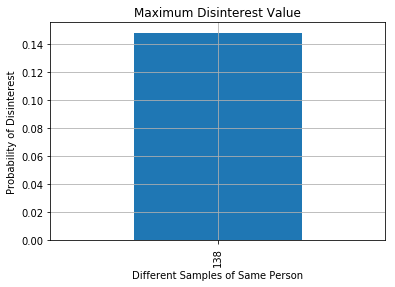

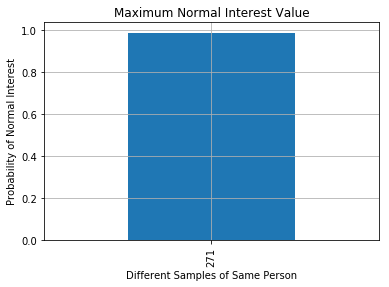

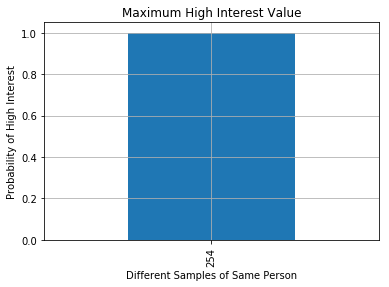

In [12]:
ax_disinterest = disinterest_c_df.plot.bar(title = 'Maximum Disinterest Value')
ax_disinterest.set_ylabel('Probability of Disinterest')
ax_disinterest.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_normal = normal_c_df.plot.bar(title = 'Maximum Normal Interest Value')
ax_normal.set_ylabel('Probability of Normal Interest')
ax_normal.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_interest = interest_c_df.plot.bar(title = 'Maximum High Interest Value')
ax_interest.set_ylabel('Probability of High Interest')
ax_interest.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

The maximum disinterest value is around ~0.15, which hints that for all samples, disinterest will be the smalles value of Level of Interest, since the sum of all values (disinterest, normal and high interest) is 1. This indicates that question askers and presenters have normal to high interest.

Now let's move on to arousal and valence.

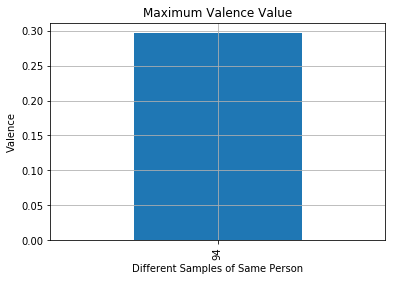

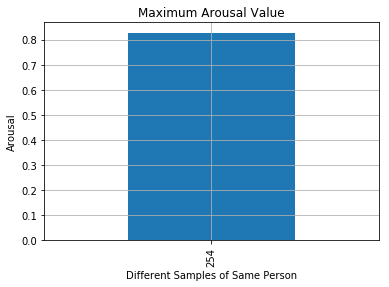

In [13]:
valence = df_ar_val_char['Valence'].idxmax()
valence_c_ID = df_ar_val_char['ID'][valence]
valence_c_df = df_ar_val_char.loc[df_ar_val_char['ID'] == valence_c_ID]
valence_c_df = valence_c_df['Valence']

arousal = df_ar_val_char['Arousal'].idxmax()
arousal_c_ID = df_ar_val_char['ID'][arousal]
arousal_c_df = df_ar_val_char.loc[df_ar_val_char['ID'] == arousal_c_ID]
arousal_c_df = arousal_c_df['Arousal']

ax_valence = valence_c_df.plot.bar(title = 'Maximum Valence Value')
ax_valence.set_ylabel('Valence')
ax_valence.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

ax_arousal = arousal_c_df.plot.bar(title = 'Maximum Arousal Value')
ax_arousal.set_ylabel('Arousal')
ax_arousal.set_xlabel('Different Samples of Same Person')
plt.grid(True)
plt.show()

The while the highest arousal value is at about 0.82, the maximum valence value is only at about 0.3.

One issue with this analysis, is that we know now that some attributes vary, but since many max values were given by question askers, who often only have one sample as they ask only one question, we don't know for sure if all attributes vary for the person with the maximum value of an attribute.

So to further investigate only samples, where there are more than one sample, we'll go ahead to the [Distinct Data Set Analysis](1_DistinctDataSetAnalysis.ipynb) notebook!